<a href="https://colab.research.google.com/github/annagossner/mba_textmining/blob/main/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Sentiment Analysis

# Imports

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier



# Reading the datasets

In [66]:
data = pd.read_csv('https://raw.githubusercontent.com/annagossner/mba_textmining/main/data/Sentiment.csv')
data.shape

(13871, 21)

# Data cleaning & preparation

In [67]:
# Convert to lowercase
data['text'] = data['text'].apply(lambda x: x.lower())

data.head()

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,...,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0000,NaN,...,NaN,5,NaN,NaN,rt @nancyleegrahn: how did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,629697200650592256,NaN,Quito
1,2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,...,NaN,26,NaN,NaN,rt @scottwalker: didn't catch the full #gopdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
2,3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,NaN,...,NaN,27,NaN,NaN,rt @tjmshow: no mention of tamir rice and the ...,NaN,2015-08-07 09:54:46 -0700,629697199312482304,NaN,NaN
3,4,No candidate mentioned,1.0,yes,1.0,Positive,1.0000,None of the above,0.7039,NaN,...,NaN,138,NaN,NaN,rt @robgeorge: that carly fiorina is trending ...,NaN,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0,yes,1.0,Positive,0.7045,None of the above,1.0000,NaN,...,NaN,156,NaN,NaN,rt @danscavino: #gopdebate w/ @realdonaldtrump...,NaN,2015-08-07 09:54:45 -0700,629697196967903232,NaN,Arizona


In [68]:
# Remove unnecessary columns
data = data[['text', 'sentiment', 'subject_matter']]

In [60]:
data.head(20)

,text,sentiment,subject_matter
0,rt nancyleegrahn how did everyone feel about t...,Neutral,None of the above
1,rt scottwalker didnt catch the full gopdebate ...,Positive,None of the above
2,rt tjmshow no mention of tamir rice and the go...,Neutral,None of the above
3,rt robgeorge that carly fiorina is trending h...,Positive,None of the above
4,rt danscavino gopdebate w realdonaldtrump deli...,Positive,None of the above
5,rt gregabbotttx tedcruz on my first day i will...,Positive,None of the above
6,rt warriorwoman91 i liked her and was happy wh...,Negative,FOX News or Moderators
7,going on msnbc live with thomasaroberts around...,Neutral,None of the above
8,deer in the headlights rt lizzwinstead ben car...,Negative,None of the above
9,rt nancyosborne180 last nights debate proved i...,Negative,None of the above


# Data exploration

subject_matter
Abortion                                 293
FOX News or Moderators                  2900
Foreign Policy                           366
Gun Control                               61
Healthcare (including Medicare)           67
Immigration                              211
Jobs and Economy                         251
LGBT issues                              126
None of the above                       8148
Racial issues                            353
Religion                                 407
Women's Issues (not abortion though)     362
Name: text, dtype: int64


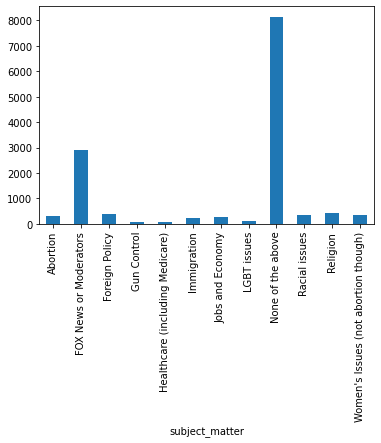

In [69]:
# How many tweets per subject?
print(data.groupby(['subject_matter'])['text'].count())
data.groupby(['subject_matter'])['text'].count().plot(kind="bar")
plt.show()

sentiment
Negative    8493
Neutral     3142
Positive    2236
Name: text, dtype: int64


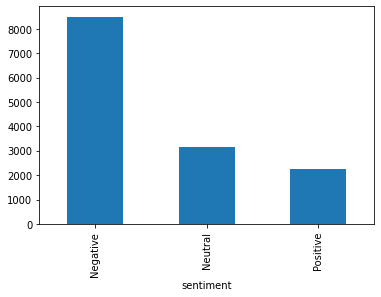

In [70]:
# How many tweets per sentiment category?
print(data.groupby(['sentiment'])['text'].count())
data.groupby(['sentiment'])['text'].count().plot(kind="bar")
plt.show()

In [71]:
# Removing neutral sentiment
data = data[data.sentiment != "Neutral"]
data.shape

(10729, 3)

In [72]:
# Splitting the dataset into train and test set
train, test = train_test_split(data,test_size = 0.1)

# Stopwords

Positive words


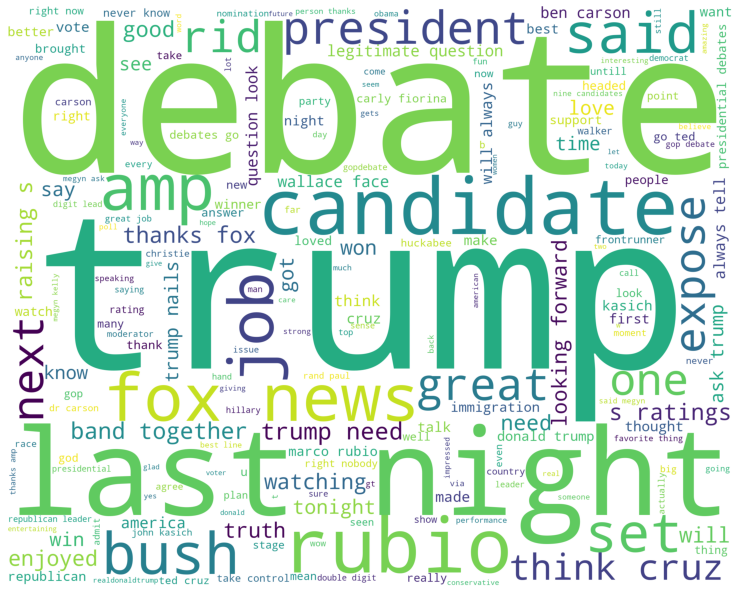

Negative words


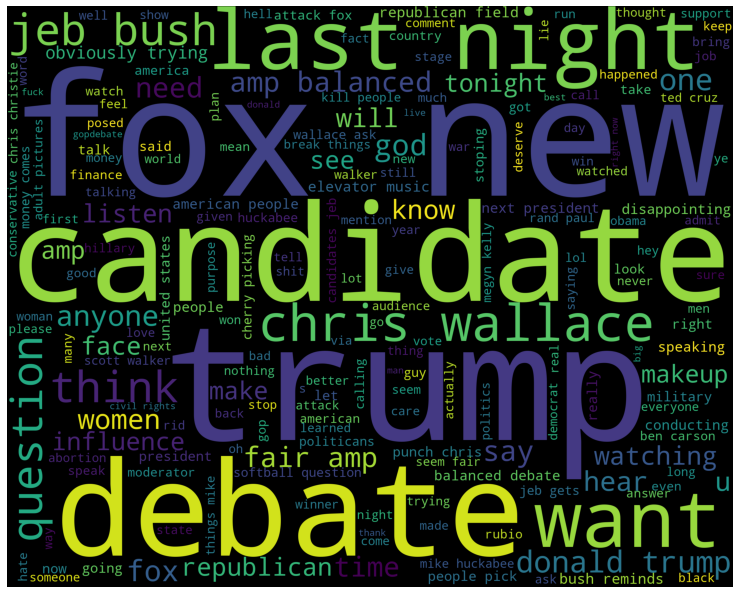

In [73]:
train_pos = train[ train['sentiment'] == 'Positive']
train_pos = train_pos['text']
train_neg = train[ train['sentiment'] == 'Negative']
train_neg = train_neg['text']

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'rt'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive words")
wordcloud_draw(train_pos,'white')
print("Negative words")
wordcloud_draw(train_neg)

In [ ]:
# tokenize?

In [74]:
tweets = []
stopwords_set = set(stopwords.words("english"))

for index, row in train.iterrows():
    words_filtered = [e.lower() for e in row.text.split() if len(e) >= 3]
    words_cleaned = [word for word in words_filtered
        if 'http' not in word
        and not word.startswith('@')
        and not word.startswith('#')
        and word != 'RT']
    words_without_stopwords = [word for word in words_cleaned if not word in stopwords_set]
    tweets.append((words_without_stopwords, row.sentiment))

test_pos = test[ test['sentiment'] == 'Positive']
test_pos = test_pos['text']
test_neg = test[ test['sentiment'] == 'Negative']
test_neg = test_neg['text']

In [75]:
# Extracting word features
def get_words_in_tweets(tweets):
    all = []
    for (words, sentiment) in tweets:
        all.extend(words)
    return all

def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    features = wordlist.keys()
    return features
w_features = get_word_features(get_words_in_tweets(tweets))

def extract_features(document):
    document_words = set(document)
    features = {}
    for word in w_features:
        features['contains(%s)' % word] = (word in document_words)
    return features

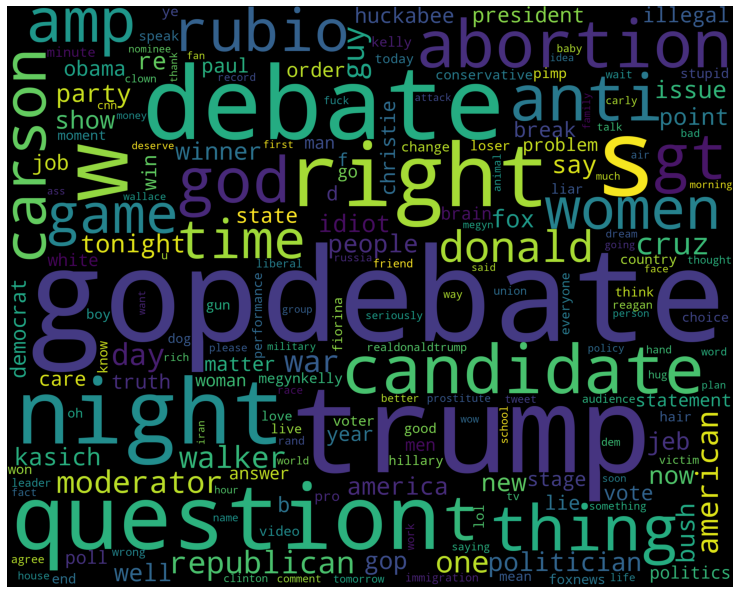

In [76]:
wordcloud_draw(w_features)

# modeling

In [98]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [99]:
# Split the data into train & test sets
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.sentiment, test_size=0.2, random_state=42)

In [110]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy (logistic regression): {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy (logistic regression): 85.27%


Text(0.5, 15.0, 'Predicted')

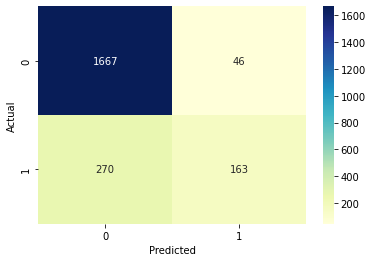

In [113]:
conf_matrix = confusion_matrix(y_test, prediction)
axes = plt.subplot
sns.heatmap(conf_matrix, annot = True, cmap = 'YlGnBu', fmt = 'g')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Decision tree classifier

In [114]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy (decision tree): {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy (decision tree): 83.69%


Text(0.5, 15.0, 'Predicted')

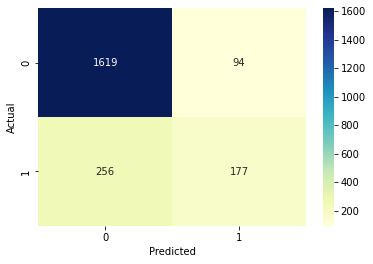

In [115]:
conf_matrix = confusion_matrix(y_test, prediction)
axes = plt.subplot
sns.heatmap(conf_matrix, annot = True, cmap = 'YlGnBu', fmt = 'g')
plt.ylabel('Actual')
plt.xlabel('Predicted')